In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import HTML, display
import numpy as np
import dataframe_image as dfi
import json
import seaborn as sns
import warnings
from IPython.display import HTML, display, Markdown
from scipy import stats

from utils.diagnostics import compute_summary_statistics
from utils.dataset_utils import aggregate_results

plt.rcParams['lines.linewidth'] = 1

In [2]:
results_path = os.path.join(os.getcwd(), "results")
data_path = os.path.join(os.getcwd(), "data", "inputs")

model_group = ["mvo", "rpo", "rbmvo", "rbmvog", "cmvo", "grbcmvo", "rbcmvo"]
estimator_group = ["mle", "nobb", "cbb", "sb"]
percentile_group = ["95", "75", "25"]

model_names = [

    "ew_lo", 

    "mvo_lo_mle_mle", 

    # "cmvo_silhouette_lo_mle_mle", 

    "rpo_lo_mle_mle_cs2006", 
    
    # "bmvo_lo_nobb_nobb_95", "bmvo_lo_cbb_cbb_95", "bmvo_lo_sb_sb_95",
    # "bmvo_lo_nobb_nobb_75", "bmvo_lo_cbb_cbb_75", "bmvo_lo_sb_sb_75",
    # "bmvo_lo_nobb_nobb_25", "bmvo_lo_cbb_cbb_25", "bmvo_lo_sb_sb_25",

    "bumvo_lo_nobb_nobb_95", "bumvo_lo_cbb_cbb_95", "bumvo_lo_sb_sb_95",
    "bumvo_lo_nobb_nobb_75", "bumvo_lo_cbb_cbb_75", "bumvo_lo_sb_sb_75",
    "bumvo_lo_nobb_nobb_25", "bumvo_lo_cbb_cbb_25", "bumvo_lo_sb_sb_25",

    # "bucmvo_silhouette_lo_nobb_nobb_95", "bucmvo_silhouette_lo_cbb_cbb_95", "bucmvo_silhouette_lo_sb_sb_95",
    # "bucmvo_silhouette_lo_nobb_nobb_75", "bucmvo_silhouette_lo_cbb_cbb_75", "bucmvo_silhouette_lo_sb_sb_75",
    # "bucmvo_silhouette_lo_nobb_nobb_25", "bucmvo_silhouette_lo_cbb_cbb_25", "bucmvo_silhouette_lo_sb_sb_25",
    
    # "bcumvo_silhouette_lo_nobb_95", "bcumvo_silhouette_lo_cbb_95", "bcumvo_silhouette_lo_sb_95",
    # "bcumvo_silhouette_lo_nobb_75", "bcumvo_silhouette_lo_cbb_75", "bcumvo_silhouette_lo_sb_75",
    # "bcumvo_silhouette_lo_nobb_25", "bcumvo_silhouette_lo_cbb_25", "bcumvo_silhouette_lo_sb_25",
]
stats_order = ["E[R]", "Std(R)", "Sharpe", "Sortino", "AvgDD", "MaxDD", "% Positive Ret."]

vol_target = 0.2

In [3]:
model_des1 = {
    
    "ew": "Equal Weight Portfolio",
    "mvo": "Mean-Variance Optimization",
    "rpo": "Robust Portfolio Optimization",
    "brpo": "Bootstrap Robust Portfolio Optimization",
    "bmvo": "Bootstrap Robust Mean-Variance Optimization",
    "bumvo": "Bootstrap Utility Robust Mean-Variance Optimization",
    "cmvo": "Cluster (SPONGE) Mean-Variance Optimization",
    "bucmvo": "Bootstrap Utility Robust Mean-Variance Optimization with Cluster (SPONGE)",
    "bcumvo": "Bootstrap Utility Double Robust Mean-Variance Optimization with Cluster (SPONGE)",

}

model_des2 = {
    
    "cs2006": "Robust Portfolio Optimization proposed by Cerias and Stubbs (2006)",
    "y2022": "Robust Portfolio Optimization proposed by Yang (2022)",

}

estimators = {

    "mle": "Maximum Likelihood Estimation",
    "nobb": "Non-overlapping Block Bootstrap",
    "cbb": "Circular Block Bootstrap",
    "sb": "Stationary Bootstrap",

}

percentiles_boot_dist = {

    "95": "95th Percentile",
    "75": "75th Percentile",
    "25": "25th Percentile",
    
}

portfolio_constraints = {

    "lo": "Long-Only",
    "ls": "Long-Short",

}

## 0) Dataset description

In [4]:
data = pd.read_csv(os.path.join(data_path, "etfs.csv"), sep=";")
data.loc[:, "date"] = pd.to_datetime(data["date"])
data.set_index("date", inplace=True)

In [5]:
data.shape

(6233, 21)

In [6]:
data.isnull().any()

SPY    False
IWM     True
EEM     True
TLT     True
USO     True
GLD     True
XLF    False
XLB    False
XLK    False
XLV    False
XLI    False
XLU    False
XLY    False
XLP    False
XLE    False
VIX    False
AGG     True
DBC     True
HYG     True
LQD     True
UUP     True
dtype: bool

In [7]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
SPY,6233.0,196.117442,104.467345,68.1100,119.270000,145.6420,255.7900,477.71
IWM,6129.0,102.577152,51.229528,32.5500,61.075000,82.1300,141.9400,242.56
EEM,5379.0,38.179273,9.271344,11.0778,34.560000,40.1100,43.7550,57.96
TLT,5564.0,110.603077,21.056923,80.6500,91.235000,107.7150,123.6600,171.57
USO,4598.0,220.720937,174.878228,17.0400,81.520000,162.2000,301.7600,939.84
GLD,4960.0,121.951588,38.906790,41.2600,96.500000,121.8600,157.2025,193.89
XLF,6233.0,22.147439,7.323794,5.0183,17.523300,22.1275,26.8600,41.42
XLB,6233.0,43.000285,18.667223,16.6300,28.030000,39.1800,53.6800,90.61
XLK,6233.0,50.667009,42.593880,11.5800,21.860000,30.2200,63.3000,185.45
XLV,6233.0,58.030363,35.206416,21.8800,30.125000,36.1600,82.0000,142.83


## 1) Summary Statistics of the Portfolios

In [8]:
all_summary = []

for model in model_names:

        output_path = os.path.join(os.getcwd(),
                                   "data",
                                   "outputs",
                                   model)
    
        try:
            summary = aggregate_results(path=output_path)
        except:
            print(f"Error: {model}")
            continue

        # read json
        args = json.load(open(os.path.join(output_path, "args.json")))
        args_df = pd.DataFrame.from_dict(args, orient="index", columns=["value"]).T
        args_df.drop(["model_name"], axis=1, inplace=True)

        for col in args_df.columns:
            if col != 'mean_cov_estimator':
                summary[col] = args_df[col].iloc[0]
            else:
                summary['mean_estimator'] = args_df[col].iloc[0]
                summary['covariance_estimator'] = args_df[col].iloc[0]


        # compute pnl
        summary["pnl"] = summary["returns"] * summary["weights"]

        # add model name
        summary["id"] = model

        # save summary
        all_summary.append(summary)
all_summary_df = pd.concat(all_summary, axis=0)

In [9]:

all_stats = {}
all_stats_des = {}
for model in model_names:

    summary_df = all_summary_df.loc[all_summary_df["id"] == model]

    portfolio_returns =  summary_df.groupby("date").sum()[["pnl"]]
    portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
    portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()

    tmp_stats = compute_summary_statistics(portfolio_returns=torch.tensor(portfolio_returns_target.values))

    all_stats[model] = tmp_stats

    tmp_stats.update({"model": summary_df["model"].unique()[0], "estimator": summary_df["mean_estimator"].unique()[0]})
    all_stats_des[model] = tmp_stats
all_stats_df = pd.DataFrame(all_stats).T[stats_order]

# dfi.export(all_stats_df, os.path.join(results_path, "all_stats_ls_df.png"))
display(HTML(all_stats_df.astype(float).round(4).to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
ew_lo,4.7450,22.3343,0.2125,0.2539,-21.2081,-54.4133,0.5026
mvo_lo_mle_mle,12.2229,20.9482,0.5835,0.7271,-17.6434,-44.3107,0.5154
rpo_lo_mle_mle_cs2006,6.7478,20.9395,0.3223,0.3916,-17.9439,-47.3731,0.5196
bumvo_lo_nobb_nobb_95,16.8755,21.6816,0.7783,0.9089,-12.3488,-40.2021,0.5245
bumvo_lo_cbb_cbb_95,15.8356,21.7014,0.7297,0.8460,-12.7308,-48.8024,0.5258
bumvo_lo_sb_sb_95,12.6528,21.2216,0.5962,0.6960,-16.8033,-46.4528,0.5188
bumvo_lo_nobb_nobb_75,12.8987,21.4464,0.6014,0.7215,-17.2316,-47.1391,0.5185
bumvo_lo_cbb_cbb_75,14.4338,21.2168,0.6803,0.8505,-13.0324,-45.2747,0.5193
bumvo_lo_sb_sb_75,14.7498,20.7882,0.7095,0.8914,-13.2496,-43.4027,0.5188
bumvo_lo_nobb_nobb_25,13.3980,20.9994,0.6380,0.7705,-17.5739,-50.2376,0.5097


In [10]:
print(all_stats_df.drop("% Positive Ret.", axis=1).astype(float).round(2).reset_index().to_latex(index=False))

\begin{tabular}{lrrrrrr}
\toprule
index & E[R] & Std(R) & Sharpe & Sortino & AvgDD & MaxDD \\
\midrule
ew_lo & 4.750000 & 22.330000 & 0.210000 & 0.250000 & -21.210000 & -54.410000 \\
mvo_lo_mle_mle & 12.220000 & 20.950000 & 0.580000 & 0.730000 & -17.640000 & -44.310000 \\
rpo_lo_mle_mle_cs2006 & 6.750000 & 20.940000 & 0.320000 & 0.390000 & -17.940000 & -47.370000 \\
bumvo_lo_nobb_nobb_95 & 16.880000 & 21.680000 & 0.780000 & 0.910000 & -12.350000 & -40.200000 \\
bumvo_lo_cbb_cbb_95 & 15.840000 & 21.700000 & 0.730000 & 0.850000 & -12.730000 & -48.800000 \\
bumvo_lo_sb_sb_95 & 12.650000 & 21.220000 & 0.600000 & 0.700000 & -16.800000 & -46.450000 \\
bumvo_lo_nobb_nobb_75 & 12.900000 & 21.450000 & 0.600000 & 0.720000 & -17.230000 & -47.140000 \\
bumvo_lo_cbb_cbb_75 & 14.430000 & 21.220000 & 0.680000 & 0.850000 & -13.030000 & -45.270000 \\
bumvo_lo_sb_sb_75 & 14.750000 & 20.790000 & 0.710000 & 0.890000 & -13.250000 & -43.400000 \\
bumvo_lo_nobb_nobb_25 & 13.400000 & 21.000000 & 0.640000 & 0.

In [11]:
display(HTML(all_stats_df.sort_values("Sharpe", ascending=False).to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
bumvo_lo_nobb_nobb_95,16.875523,21.681613,0.778333,0.908887,-12.348842,-40.202094,0.524543
bumvo_lo_cbb_cbb_95,15.835611,21.70145,0.729703,0.845967,-12.730841,-48.802444,0.525849
bumvo_lo_sb_sb_75,14.749843,20.788182,0.70953,0.891376,-13.24964,-43.402655,0.518799
bumvo_lo_cbb_cbb_75,14.433834,21.21684,0.680301,0.850465,-13.032423,-45.274748,0.519321
bumvo_lo_nobb_nobb_25,13.397992,20.999357,0.638019,0.770541,-17.573899,-50.237643,0.509661
bumvo_lo_nobb_nobb_75,12.898661,21.446431,0.601436,0.721494,-17.231634,-47.139093,0.518538
bumvo_lo_sb_sb_95,12.652779,21.221643,0.596221,0.696043,-16.803281,-46.452808,0.518799
bumvo_lo_sb_sb_25,12.173616,20.662971,0.589151,0.763677,-13.634992,-36.906013,0.509661
mvo_lo_mle_mle,12.222865,20.948228,0.58348,0.72712,-17.64343,-44.310656,0.515405
bumvo_lo_cbb_cbb_25,11.035724,20.89903,0.52805,0.634787,-17.570908,-41.243827,0.524021


In [12]:
display(HTML(all_stats_df.sort_values("Sortino", ascending=False).to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
bumvo_lo_nobb_nobb_95,16.875523,21.681613,0.778333,0.908887,-12.348842,-40.202094,0.524543
bumvo_lo_sb_sb_75,14.749843,20.788182,0.70953,0.891376,-13.24964,-43.402655,0.518799
bumvo_lo_cbb_cbb_75,14.433834,21.21684,0.680301,0.850465,-13.032423,-45.274748,0.519321
bumvo_lo_cbb_cbb_95,15.835611,21.70145,0.729703,0.845967,-12.730841,-48.802444,0.525849
bumvo_lo_nobb_nobb_25,13.397992,20.999357,0.638019,0.770541,-17.573899,-50.237643,0.509661
bumvo_lo_sb_sb_25,12.173616,20.662971,0.589151,0.763677,-13.634992,-36.906013,0.509661
mvo_lo_mle_mle,12.222865,20.948228,0.58348,0.72712,-17.64343,-44.310656,0.515405
bumvo_lo_nobb_nobb_75,12.898661,21.446431,0.601436,0.721494,-17.231634,-47.139093,0.518538
bumvo_lo_sb_sb_95,12.652779,21.221643,0.596221,0.696043,-16.803281,-46.452808,0.518799
bumvo_lo_cbb_cbb_25,11.035724,20.89903,0.52805,0.634787,-17.570908,-41.243827,0.524021


In [13]:
display(HTML(all_stats_df.sort_values("AvgDD", ascending=False).to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
bumvo_lo_nobb_nobb_95,16.875523,21.681613,0.778333,0.908887,-12.348842,-40.202094,0.524543
bumvo_lo_cbb_cbb_95,15.835611,21.70145,0.729703,0.845967,-12.730841,-48.802444,0.525849
bumvo_lo_cbb_cbb_75,14.433834,21.21684,0.680301,0.850465,-13.032423,-45.274748,0.519321
bumvo_lo_sb_sb_75,14.749843,20.788182,0.70953,0.891376,-13.24964,-43.402655,0.518799
bumvo_lo_sb_sb_25,12.173616,20.662971,0.589151,0.763677,-13.634992,-36.906013,0.509661
bumvo_lo_sb_sb_95,12.652779,21.221643,0.596221,0.696043,-16.803281,-46.452808,0.518799
bumvo_lo_nobb_nobb_75,12.898661,21.446431,0.601436,0.721494,-17.231634,-47.139093,0.518538
bumvo_lo_cbb_cbb_25,11.035724,20.89903,0.52805,0.634787,-17.570908,-41.243827,0.524021
bumvo_lo_nobb_nobb_25,13.397992,20.999357,0.638019,0.770541,-17.573899,-50.237643,0.509661
mvo_lo_mle_mle,12.222865,20.948228,0.58348,0.72712,-17.64343,-44.310656,0.515405


In [14]:
display(HTML(all_stats_df.sort_values("MaxDD", ascending=False).to_html()))

,E[R],Std(R),Sharpe,Sortino,AvgDD,MaxDD,% Positive Ret.
bumvo_lo_sb_sb_25,12.173616,20.662971,0.589151,0.763677,-13.634992,-36.906013,0.509661
bumvo_lo_nobb_nobb_95,16.875523,21.681613,0.778333,0.908887,-12.348842,-40.202094,0.524543
bumvo_lo_cbb_cbb_25,11.035724,20.89903,0.52805,0.634787,-17.570908,-41.243827,0.524021
bumvo_lo_sb_sb_75,14.749843,20.788182,0.70953,0.891376,-13.24964,-43.402655,0.518799
mvo_lo_mle_mle,12.222865,20.948228,0.58348,0.72712,-17.64343,-44.310656,0.515405
bumvo_lo_cbb_cbb_75,14.433834,21.21684,0.680301,0.850465,-13.032423,-45.274748,0.519321
bumvo_lo_sb_sb_95,12.652779,21.221643,0.596221,0.696043,-16.803281,-46.452808,0.518799
bumvo_lo_nobb_nobb_75,12.898661,21.446431,0.601436,0.721494,-17.231634,-47.139093,0.518538
rpo_lo_mle_mle_cs2006,6.74777,20.939509,0.322251,0.391626,-17.943938,-47.373148,0.519582
bumvo_lo_cbb_cbb_95,15.835611,21.70145,0.729703,0.845967,-12.730841,-48.802444,0.525849


## 2) Cummulative Returns of the Portfolios

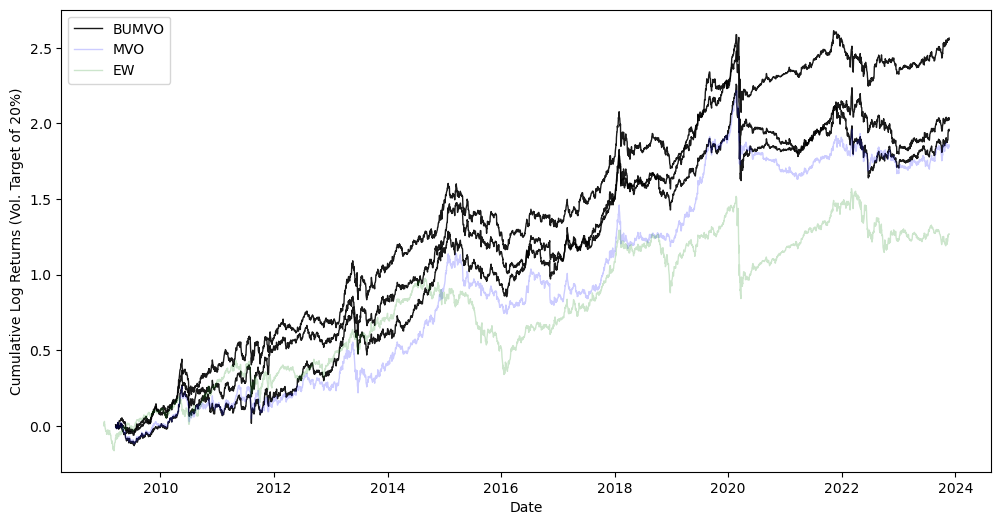

In [15]:
super_benchmarks = ['mvo_lo_mle_mle', 'ew_lo']
selected_model_list = [
   'bumvo_lo_nobb_nobb_95', # 'bumvo_lo_cbb_cbb_95', 'bumvo_lo_sb_sb_95',
   'bumvo_lo_nobb_nobb_75', # 'bumvo_lo_cbb_cbb_75', 'bumvo_lo_sb_sb_75',
   'bumvo_lo_nobb_nobb_25', # 'bumvo_lo_cbb_cbb_25', 'bumvo_lo_sb_sb_25',
]

# Group models 
treatment_models = [m for m in selected_model_list if m.startswith('bumvo')]

# Define colors for each group
colors = {
   'bumvo': 'red',
   'mvo_lo_mle_mle': 'blue', 
   'ew_lo': 'green',
}

fig, ax = plt.subplots(figsize=(12, 6))

# Plot naive models in blue
for model in treatment_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='black', alpha=0.9)

# Plot mvo models in red  
for model in super_benchmarks:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color=colors[model], alpha=0.2)

# Add representative lines for legend
plt.plot([], [], color='black', label='BUMVO', alpha=0.9)
plt.plot([], [], color='blue', label='MVO', alpha=0.2)
plt.plot([], [], color='green', label='EW', alpha=0.2)

# plt.title(f"BUMVO vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 20%)")
plt.xlabel("Date")
plt.legend( loc='upper left') # bbox_to_anchor=(1.05, 1))
# plt.grid(True)
plt.show()

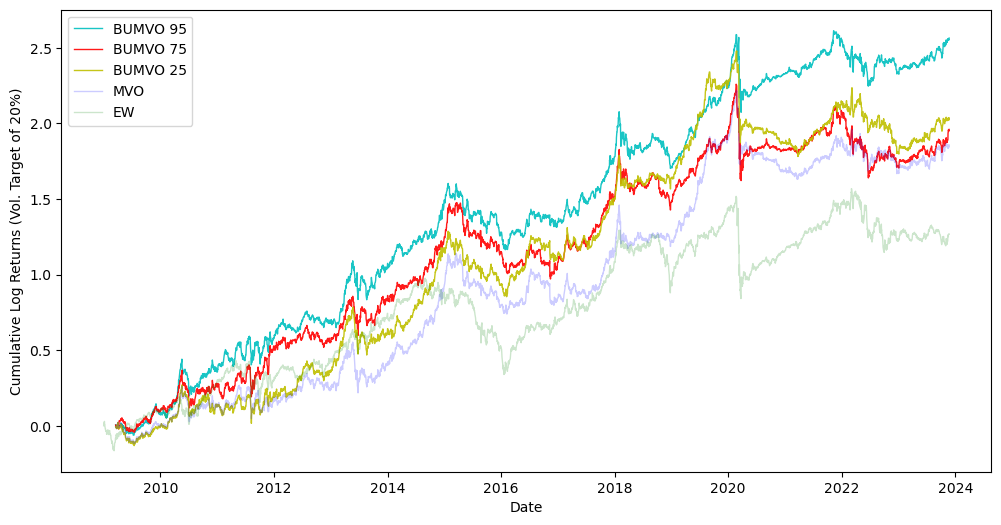

In [16]:
super_benchmarks = ['mvo_lo_mle_mle', 'ew_lo']
selected_model_list = [
   'bumvo_lo_nobb_nobb_95', # 'bumvo_lo_cbb_cbb_95', 'bumvo_lo_sb_sb_95',
   'bumvo_lo_nobb_nobb_75', # 'bumvo_lo_cbb_cbb_75', 'bumvo_lo_sb_sb_75',
   'bumvo_lo_nobb_nobb_25', # 'bumvo_lo_cbb_cbb_25', 'bumvo_lo_sb_sb_25',
]

# Group models 
p95_models = [m for m in selected_model_list if '95' in m]
p75_models = [m for m in selected_model_list if '75' in m]
p25_models = [m for m in selected_model_list if '25' in m]

# Define colors for each group
colors = {
   'bumvo': 'red',
   'mvo_lo_mle_mle': 'blue', 
   'ew_lo': 'green',
}

fig, ax = plt.subplots(figsize=(12, 6))

# Plot naive models in blue
for model in p95_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='c', alpha=0.9)

# Plot naive models in blue
for model in p75_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='r', alpha=0.9)

# Plot naive models in blue
for model in p25_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='y', alpha=0.9)

# Plot mvo models in red  
for model in super_benchmarks:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color=colors[model], alpha=0.2)

# Add representative lines for legend
plt.plot([], [], color='c', label='BUMVO 95', alpha=0.9)
plt.plot([], [], color='r', label='BUMVO 75', alpha=0.9)
plt.plot([], [], color='y', label='BUMVO 25', alpha=0.9)
plt.plot([], [], color='blue', label='MVO', alpha=0.2)
plt.plot([], [], color='green', label='EW', alpha=0.2)

# plt.title(f"BUMVO vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 20%)")
plt.xlabel("Date")
plt.legend(loc='upper left') # , bbox_to_anchor=(1.05, 1))
# plt.grid(True)
plt.show()

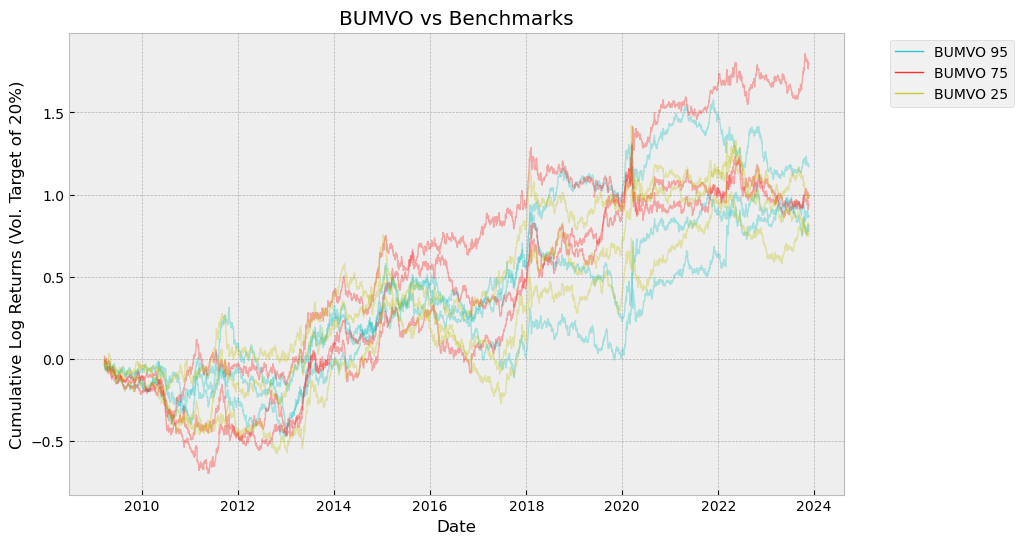

In [83]:
super_benchmarks = ['mvo_ls_mle_mle', 'ew_lo']
selected_model_list = [
   'bumvo_ls_nobb_nobb_95', 'bumvo_ls_cbb_cbb_95', 'bumvo_ls_sb_sb_95',
   'bumvo_ls_nobb_nobb_75', 'bumvo_ls_cbb_cbb_75', 'bumvo_ls_sb_sb_75',
   'bumvo_ls_nobb_nobb_25', 'bumvo_ls_cbb_cbb_25', 'bumvo_ls_sb_sb_25',
]

# Group models 
p95_models = [m for m in selected_model_list if '95' in m]
p75_models = [m for m in selected_model_list if '75' in m]
p25_models = [m for m in selected_model_list if '25' in m]

# Define colors for each group
colors = {
   'bumvo': 'red',
   'mvo_ls_mle_mle': 'blue', 
   'ew_lo': 'green',
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in p95_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='c', alpha=0.3)

# Plot naive models in blue
for model in p75_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='r', alpha=0.3)

# Plot naive models in blue
for model in p25_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='y', alpha=0.3)

# Add representative lines for legend
plt.plot([], [], color='c', label='BUMVO 95', alpha=0.8)
plt.plot([], [], color='r', label='BUMVO 75', alpha=0.8)
plt.plot([], [], color='y', label='BUMVO 25', alpha=0.8)

plt.title(f"BUMVO vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 20%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
plt.show()

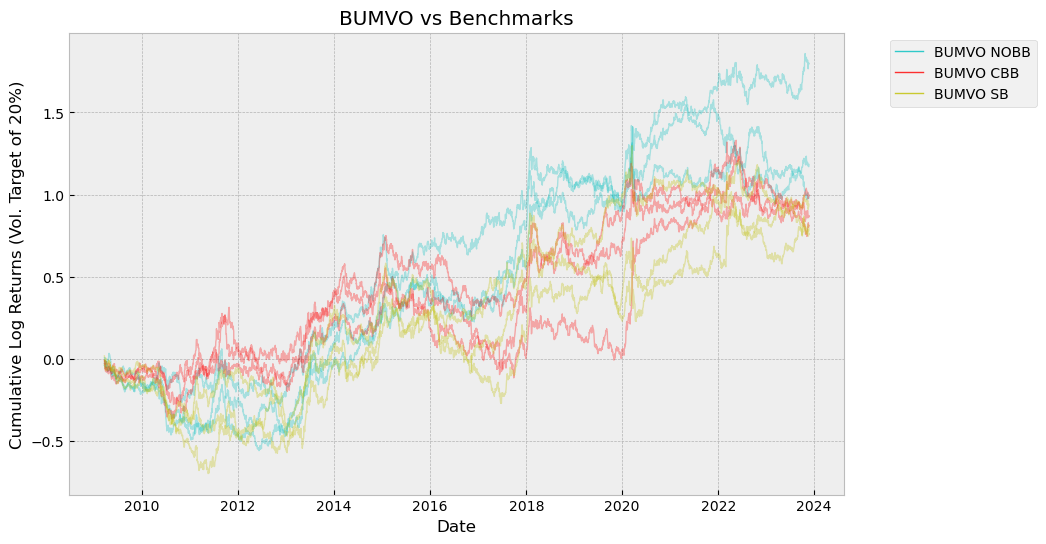

In [84]:
super_benchmarks = ['mvo_ls_mle_mle', 'ew_lo']
selected_model_list = [
   'bumvo_ls_nobb_nobb_95', 'bumvo_ls_cbb_cbb_95', 'bumvo_ls_sb_sb_95',
   'bumvo_ls_nobb_nobb_75', 'bumvo_ls_cbb_cbb_75', 'bumvo_ls_sb_sb_75',
   'bumvo_ls_nobb_nobb_25', 'bumvo_ls_cbb_cbb_25', 'bumvo_ls_sb_sb_25',
]

# Group models 
nobb_models = [m for m in selected_model_list if 'nobb' in m]
cbb_models = [m for m in selected_model_list if 'cbb' in m]
sb_models = [m for m in selected_model_list if 'sb' in m]

# Define colors for each group
colors = {
   'bumvo': 'red',
   'mvo_ls_mle_mle': 'blue', 
   'ew_lo': 'green',
}

fig, ax = plt.subplots(figsize=(10, 6))

# Plot naive models in blue
for model in nobb_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='c', alpha=0.3)

# Plot naive models in blue
for model in cbb_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='r', alpha=0.3)

# Plot naive models in blue
for model in sb_models:
   portfolio_returns = all_summary_df.loc[all_summary_df["id"] == model].pivot_table(index="date", columns="id", values="pnl")
   portfolio_vol = (portfolio_returns.rolling(window=252).std() * np.sqrt(252)).shift(1)
   portfolio_returns_target = (portfolio_returns * (vol_target / portfolio_vol)).dropna()
   cum_pnl_df = portfolio_returns_target.loc["2009-01-01":].cumsum()
   cum_pnl_df.index = pd.to_datetime(cum_pnl_df.index)

   plt.plot(cum_pnl_df.index, cum_pnl_df[model], color='y', alpha=0.3)

# Add representative lines for legend
plt.plot([], [], color='c', label='BUMVO NOBB', alpha=0.8)
plt.plot([], [], color='r', label='BUMVO CBB', alpha=0.8)
plt.plot([], [], color='y', label='BUMVO SB', alpha=0.8)

plt.title(f"BUMVO vs Benchmarks")
plt.ylabel("Cumulative Log Returns (Vol. Target of 20%)")
plt.xlabel("Date")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.grid(True)
plt.show()